# Practical 7 - Part 2B - Zuohe Zheng
The goal of this part of the practical is to take a real image containing
a planar black square and figure out the transformation between the square
and the camera.  We will then draw a wire-frame cube with it's base
corners at the corner of the square.  You should use this
template for your code and fill in the missing sections marked "TO DO"

# Import libraries 

In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# Load and display the image

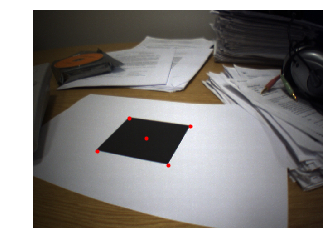

In [2]:
# Load image:
im = plt.imread('test104.jpg')

# Define points on image
XImCart = np.array([[140.3464,  212.1129,  346.3065,  298.1344,   247.9962],
             [308.9825,  236.7646,  255.4416,  340.7335,   281.5895]])

# Define 3D points of plane
XCart = np.array([[-50, -50,  50,  50, 0],
          [50, -50, -50,  50, 0],
          [0,   0,   0,   0, 0]])

# We assume that the intrinsic camera matrix K is known and has values:
K = np.array([[640,  0,  320],
             [0, 640, 240],
             [0,  0,  1]])

# Draw image and 2d points
plt.imshow(im)
plt.plot(XImCart[0,],XImCart[1,],'r.')
plt.axis('off')
plt.show()

In [3]:
#The goal of this function is to project points in XCart through projective camera
#defined by intrinsic matrix K and extrinsic matrix T.
def projectiveCamera(K,T,XCart):
    
    # TO DO: Replace this
    # XImCart =

    # TO DO: Convert Cartesian 3d points XCart to homogeneous coordinates XHom
    # by appending a row of 1 to the original point coordinates to form [u,v,w,1]
    XHom = np.concatenate((XCart, np.ones((1,XCart.shape[1]))), axis=0)
    # TO DO: Apply extrinsic matrix to XHom, to move to frame of reference of camera
    # = lambda * [x',y',1, 1/lambda]
    xCamHom1 = T @ XHom
    # TO DO: Project points into normalized camera coordinates xCamHom (remove 4th row)
    # = lambda * [x',y',1]
    xCamHom = xCamHom1[0:3,:]
    # TO DO: Move points to image coordinates xImHom by applying intrinsic matrix
    # = lambda * [x,y,1]
    xImHom = K @ xCamHom
    # TO DO: Convert points back to Cartesian coordinates xImCart
    # x = (lambda * x) / lambda
    # y = (lambda * y) / lambda
    XImCart = xImHom[0:2,:] / np.tile([xImHom[2,:]],(2,1))
    return XImCart

In [4]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0   
    h = np.zeros(shape = [np.size(A),1])
    [U,L,Vt] = np.linalg.svd(A)
    V = np.transpose(Vt)
    h = V[:,-1]
    return h

In [5]:
# Goal of function is to estimate pose of plane relative to camera (extrinsic matrix)
# given points in image xImCart, points in world XCart and intrinsic matrix K

def estimatePlanePose(XImCart,XCart,K):

    # TO DO: replace this
    #T = 

    # TO DO: Convert Cartesian image points XImCart to homogeneous representation XImHom
    # by appending a row of 1 to the original point coordinates to form [x,y,1]
    XImHom = np.concatenate((XImCart, np.ones((1,XImCart.shape[1]))), axis=0)
    
    # TO DO: Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    # multiply with inverse of intrinsic matrix
    XCamHom = np.linalg.inv(K) @ XImHom
    
    # TO DO: Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    
    # Extract the u and v coordinates of Cartesian 3d points XCart
    XCart = XCart[0:2,:]
    
    # Convert XCart to homogeneous coordinates XCartHom
    # [u,v] to [u,v,1]
    XCartHom = np.concatenate((XCart, np.ones((1,XCart.shape[1]))), axis=0)
    
    # Then construct the matrix A, size (n_points,9) 
    n_points = np.shape(XCamHom)[1]
    A = np.zeros(shape = [n_points*2,9])
    for n in range(n_points):
        A[2*n,[0,1,2]] = 0
        A[2*n,[3,4,5]] = -XCartHom[:,n]
        A[2*n,[6,7,8]] = XCartHom[:,n] * XCamHom[1,n]
        A[2*n+1,[0,1,2]] = XCartHom[:,n]
        A[2*n+1,[3,4,5]] = 0
        A[2*n+1,[6,7,8]] = -XCartHom[:,n] * XCamHom[0,n]
    
    # Solve Ah = 0
    h = solveAXEqualsZero(A)
    # Reshape h into the matrix H, values of h go first into rows of H
    h_width = np.sqrt(np.size(h))
    h_width = int(h_width)
    H = np.reshape(h,[h_width,h_width])
     
    # TO DO: Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD
    # SVD decomposition of the first two columns of H
    [U,L,Vt] = np.linalg.svd(H[:,0:2])
    R = np.zeros(shape=[h_width,h_width])
    # Replace L with [1,0;0,1;0,0] to form the first two columns of R
    l = np.array([[1,0],[0,1],[0,0]])
    R[:,0:2] = U @ l @ Vt

    # TO DO: Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    R[:,2] = np.cross(R[:,0],R[:,1])
        
    # TO DO: Check that the determinant of the rotation matrix is positive - if
    # not then multiply last column by -1.
    if np.linalg.det(R) <= 0 :
        R[:,-1] = - R[:,-1]
    
    # TO DO: Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    # Find translation scaling factor between old and new values
    Lamb = H / R
    lamb = np.sum(Lamb[0:3,0:2]) / 6
    t = H[:,-1] / lamb
    
    # TO DO: Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if t[-1] < 0 :
        t = -t
        R[:,0:2] = -R[:,0:2]
    
            
    # TO DO: Assemble transformation into matrix form
    # append [Tx,Ty,Tz] to R as the last column
    # then append [0,0,0,1] as the last row to form the final transformation matrix
    t = np.reshape(t,[3,1])
    T = np.concatenate((R, t), axis=1)
    T = np.concatenate((T, np.array([[0,0,0,1]])), axis=0)
    
    return T 

# **** TO DO **** apply the functions from part 2A  (estimatePlanePose, projectiveCamera) to take the image and figure out the transformation between the square and the camera. 

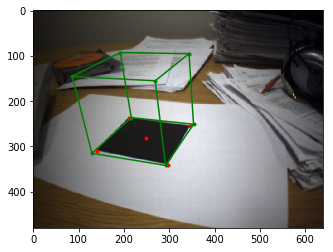

In [12]:
# TO DO: Use your routine to calculate TEst, the extrinsic matrix relating the
# plane position to the camera position.


# Define 3D points of plane
XWireFrameCart = np.array([[-50, -50,  50,  50, -50, -50,  50,  50],
                   [50, -50, -50,  50,  50, -50, -50,  50],
                    [0,   0,   0,   0, -100, -100, -100, -100]]);


# TO DO: Draw a wire frame cube, by projecting the vertices of a 3D cube through
# the projective camera and drawing lines betweeen the resulting 2d image points
TEst = estimatePlanePose(XImCart,XCart,K)
XWireFrameCartProjected = projectiveCamera(K,TEst,XWireFrameCart)

# Draw image, 2d points and projected 3D cube points
plt.imshow(im)
plt.plot(XImCart[0,],XImCart[1,],'r.')
plt.plot(XWireFrameCartProjected[0,],XWireFrameCartProjected[1,],'g.')

# Connect the points to draw the frame of the cube
for cPoint in range(4):
    plt.plot([XWireFrameCartProjected[0,cPoint],XWireFrameCartProjected[0,cPoint+4]], \
             [XWireFrameCartProjected[1,cPoint],XWireFrameCartProjected[1,cPoint+4]],'g-') 
for cPoint in range(3):
    plt.plot([XWireFrameCartProjected[0,cPoint],XWireFrameCartProjected[0,cPoint+1]], \
             [XWireFrameCartProjected[1,cPoint],XWireFrameCartProjected[1,cPoint+1]],'g-') 
    plt.plot([XWireFrameCartProjected[0,cPoint+4],XWireFrameCartProjected[0,cPoint+5]], \
             [XWireFrameCartProjected[1,cPoint+4],XWireFrameCartProjected[1,cPoint+5]],'g-')
plt.plot([XWireFrameCartProjected[0,0],XWireFrameCartProjected[0,3]], \
             [XWireFrameCartProjected[1,0],XWireFrameCartProjected[1,3]],'g-') 
plt.plot([XWireFrameCartProjected[0,4],XWireFrameCartProjected[0,7]], \
             [XWireFrameCartProjected[1,4],XWireFrameCartProjected[1,7]],'g-') 

# plt.axis('off')
plt.show()

# QUESTIONS TO THINK ABOUT...

Do the results look realistic?
If not, then what factors do you think might be causing this?

The figure above shows a wire-frame cube transformed from the given 3D points, with it's base corners at the corner of the square. The estimated pose of plane relative to camera can correctly project the vertices of 3D cube through the projective camera. However, the result is not very realistic because the edges of the cube is straight compared to other objects in the scene that have radical distortion under camera.